In [ ]:
!pip install sentence_transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##Distribution of labels

In [ ]:
import pandas as pd

# Load the training data into a pandas DataFrame
train_data = pd.read_csv('train_capital.csv')

# Print the count of each label in the training data
label_counts = train_data['stance'].value_counts()
print(label_counts)


against    466
favour     323
neutral    209
Name: stance, dtype: int64


##sentence embedding 

In [ ]:
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier

df = pd.read_csv('train_capital.csv')

# Pre-trained sentence embedding model
model = SentenceTransformer('sentence-transformers/paraphrase-xlm-r-multilingual-v1')
#model = SentenceTransformer('bert-base-nli-mean-tokens')


# Extract sentence embeddings for the Telugu tweets
embeddings = model.encode(df['text'].tolist())

def extract_keywords(texts):
    vectorizer = TfidfVectorizer(max_features=25)
    vectorizer.fit(texts)
    tfidf_scores = vectorizer.transform(texts)
    tfidf_scores_array = tfidf_scores.toarray()
    documents = []
    for row in tfidf_scores_array:
        document = ' '.join([str(score) for score in row])
        documents.append(document)
    return documents

keywords = extract_keywords(df['text'].tolist())

# Combine the sentence embeddings and keyword features
features = []
for i in range(len(embeddings)):
    feature = list(embeddings[i]) + list(keywords[i])
    features.append(feature)


# Encode the stance labels using label encoding
le = LabelEncoder()
df['stance_label'] = le.fit_transform(df['stance'])

df['sentence_embedding'] = df['text'].apply(lambda x: model.encode(x))

vectorizer = TfidfVectorizer()
X_keywords = vectorizer.fit_transform(df['text'])

# Combine the sentence embeddings and keyword features to create a final feature vector for each tweet
X_sentence = pd.DataFrame(df['sentence_embedding'].tolist())
X = pd.concat([X_sentence, pd.DataFrame(X_keywords.toarray())], axis=1)


##Bagging

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X[:800], df['stance_label'][:800], test_size=0.2, random_state=10)

# Initialize a decision tree classifier
clf = DecisionTreeClassifier()

# Initialize a bagging classifier with 10 decision tree classifiers
bagging_clf = BaggingClassifier(estimator=clf, n_estimators=50, random_state=42)

# Train the bagging classifier on the first 800 lines of the dataset
bagging_clf.fit(X_train, y_train)

# Make predictions on the next 200 lines of the dataset
y_pred = bagging_clf.predict(X[800:1000])

# Evaluate the performance of the trained model on the next 200 lines of the dataset
acc1 = accuracy_score(df['stance_label'][800:1000], y_pred)
precision1, recall1, f1_score1, support1 = precision_recall_fscore_support(df['stance_label'][800:1000], y_pred)

# Print the evaluation metrics
print('Accuracy:', acc1)
print('Precision:', precision1)
print('Recall:', recall1)
print('F1-Score:', f1_score1)
print('Support:', support1)


Accuracy: 0.6161616161616161
Precision: [0.625      0.62162162 0.25      ]
Recall: [0.78947368 0.6969697  0.02702703]
F1-Score: [0.69767442 0.65714286 0.04878049]
Support: [95 66 37]


##AdaBoost

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X[:800], df['stance_label'][:800], test_size=0.2, random_state=10)

# Initialize a decision tree classifier
clf = DecisionTreeClassifier()

# Initialize an Adaboost classifier with 50 decision tree classifiers
adaboost_clf = AdaBoostClassifier(estimator=clf, n_estimators=100, random_state=42)

# Train the Adaboost classifier on the training set
adaboost_clf.fit(X_train, y_train)

# Make predictions on the next 200 lines of the dataset
y_pred = adaboost_clf.predict(X[800:1000])

# Evaluate the performance of the trained model on the next 200 lines of the dataset
acc2 = accuracy_score(df['stance_label'][800:1000], y_pred)
precision2, recall2, f1_score2, support2 = precision_recall_fscore_support(df['stance_label'][800:1000], y_pred)

# Print the evaluation metrics
print('Accuracy:', acc2)
print('Precision:', precision2)
print('Recall:', recall2)
print('F1-Score:', f1_score2)
print('Support:', support2)


Accuracy: 0.4393939393939394
Precision: [0.49038462 0.40983607 0.33333333]
Recall: [0.53684211 0.37878788 0.2972973 ]
F1-Score: [0.51256281 0.39370079 0.31428571]
Support: [95 66 37]


##GradientBoost

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X[:800], df['stance_label'][:800], test_size=0.2, random_state=42)

# Train a Gradient Boosting model on the training set
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=42)
gb.fit(X_train, y_train)

# Make predictions on the test set
y_pred = gb.predict(X[800:1000])

# Evaluate the performance of the trained model on the test set
acc3 = accuracy_score(df['stance_label'][800:1000], y_pred)
precision3, recall3, f1_score3, support3 = precision_recall_fscore_support(df['stance_label'][800:1000], y_pred)

# Print the evaluation metrics
print('Accuracy:', acc3)
print('Precision:', precision3)
print('Recall:', recall3)
print('F1-Score:', f1_score3)
print('Support:', support3)


Accuracy: 0.898989898989899
Precision: [0.89320388 0.890625   0.93548387]
Recall: [0.96842105 0.86363636 0.78378378]
F1-Score: [0.92929293 0.87692308 0.85294118]
Support: [95 66 37]


In [ ]:
new_data = pd.read_csv('/content/test_capital.csv')

# Extract sentence embeddings for the new data
new_data['sentence_embedding'] = new_data['text'].apply(lambda x: model.encode(x))

# Append keyword features to the sentence embeddings
new_data_keywords = vectorizer.transform(new_data['text'])
new_data_features = pd.concat([pd.DataFrame(new_data['sentence_embedding'].tolist()), pd.DataFrame(new_data_keywords.toarray())], axis=1)

# Make predictions on the new data
new_data_predictions = le.inverse_transform(gb.predict(new_data_features))

# Save the predictions to a CSV file
new_data['stance'] = new_data_predictions
new_data.to_csv('new_capital_predictions.csv', index=False)

# Print the predictions
print('New data predictions:', new_data_predictions)


New data predictions: ['favour' 'neutral' 'neutral' 'favour' 'against' 'against' 'against'
 'against' 'against' 'favour' 'favour' 'against' 'against' 'favour'
 'favour' 'favour' 'favour' 'against' 'against' 'against' 'favour'
 'against' 'against' 'favour' 'favour' 'favour' 'neutral' 'against'
 'against' 'against' 'favour' 'against' 'against' 'favour' 'against'
 'against' 'favour' 'neutral' 'favour' 'against' 'against' 'against'
 'against' 'against' 'neutral' 'favour' 'neutral' 'favour' 'favour'
 'against' 'favour' 'against' 'favour' 'against' 'against' 'against'
 'against' 'neutral' 'favour' 'against' 'favour' 'favour' 'against'
 'against' 'against' 'against' 'favour' 'neutral' 'favour' 'against'
 'neutral' 'neutral' 'neutral' 'neutral' 'favour' 'against' 'against'
 'against' 'against' 'favour' 'against' 'against' 'favour' 'against'
 'against' 'favour' 'against' 'neutral' 'neutral' 'favour' 'favour'
 'neutral' 'favour' 'favour' 'against' 'against' 'favour' 'favour'
 'neutral' 'favour' 

##Confusion Matrix

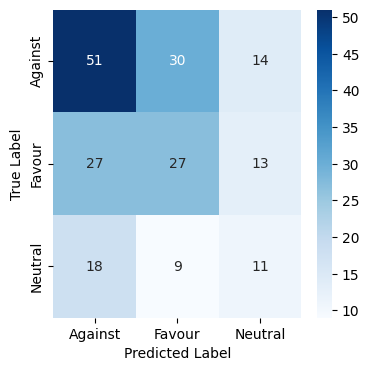

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(df['stance_label'][798:1000], y_pred)

# Create a heatmap visualization of the confusion matrix
fig, ax = plt.subplots(figsize=(4, 4))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=['Against', 'Favour', 'Neutral'], yticklabels=['Against', 'Favour', 'Neutral'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

##MLP

In [ ]:
from sklearn.neural_network import MLPClassifier

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X[:800], df['stance_label'][:800], test_size=0.2, random_state=10)

# Train an MLP classifier on the training set
mlp = MLPClassifier(hidden_layer_sizes=(10,), activation='relu', solver='adam', max_iter=100, random_state=42)
mlp.fit(X_train, y_train)

# Make predictions on the test set
y_pred = mlp.predict(X[800:1000])
# Evaluate the performance of the trained model on the test set
acc4 = accuracy_score(df['stance_label'][800:1000], y_pred)
precision4, recall4, f1_score4, support4 = precision_recall_fscore_support(df['stance_label'][800:1000], y_pred)

# Print the evaluation metrics
print('Accuracy:', acc4)
print('Precision:', precision4)
print('Recall:', recall4)
print('F1-Score:', f1_score4)
print('Support:', support4)


Accuracy: 0.5757575757575758
Precision: [0.67010309 0.52857143 0.38709677]
Recall: [0.68421053 0.56060606 0.32432432]
F1-Score: [0.67708333 0.54411765 0.35294118]
Support: [95 66 37]


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


##RandomForest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X[:800], df['stance_label'][:800], test_size=0.2, random_state=10)

# Train a Random Forest classifier on the training set
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf.predict(X[800:1000])

# Evaluate the performance of the trained model on the test set
acc6 = accuracy_score(df['stance_label'][800:1000], y_pred)
precision6, recall6, f1_score6, support6 = precision_recall_fscore_support(df['stance_label'][800:1000], y_pred)

# Print the evaluation metrics
print('Accuracy:', acc6)
print('Precision:', precision6)
print('Recall:', recall6)
print('F1-Score:', f1_score6)
print('Support:', support6)


Accuracy: 0.5606060606060606
Precision: [0.57664234 0.53448276 0.33333333]
Recall: [0.83157895 0.46969697 0.02702703]
F1-Score: [0.68103448 0.5        0.05      ]
Support: [95 66 37]


##Naive Bayes

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Create a bag-of-words representation of the text data
vectorizer = CountVectorizer()
X_bow = vectorizer.fit_transform(df['text'])

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_bow, df['stance_label'], test_size=0.2, random_state=10)

# Train a Naive Bayes classifier on the training set
nb = MultinomialNB()
nb.fit(X_train, y_train)

# Make predictions on the test set
y_pred = nb.predict(X_test)

# Evaluate the performance of the trained model on the test set
acc5 = accuracy_score(y_test, y_pred)
precision5, recall5, f1_score5, support5 = precision_recall_fscore_support(y_test, y_pred)

# Print the evaluation metrics
print('Accuracy:', acc5)
print('Precision:', precision5)
print('Recall:', recall5)
print('F1-Score:', f1_score5)
print('Support:', support5)


Accuracy: 0.495
Precision: [0.56097561 0.39344262 0.375     ]
Recall: [0.71134021 0.40677966 0.13636364]
F1-Score: [0.62727273 0.4        0.2       ]
Support: [97 59 44]


In [ ]:
print("Accuracy of Bagging Classifier",acc1,acc2,acc3,acc4,acc5,acc6)
print("Accuracy of Gradient Boosting Classifierr",acc3)
print("Accuracy of AdaBoost Classifier",acc2)
print("Accuracy of Multi-layer Perceptron Classifier",acc4)
print("Accuracy of Gaussian Naive Bayes Classifier",acc5)
print("Accuracy of Random Forest Classifier",acc6)

Accuracy of Bagging Classifier 0.6161616161616161 0.4393939393939394 0.898989898989899 0.5757575757575758 0.495 0.5606060606060606
Accuracy of Gradient Boosting Classifierr 0.898989898989899
Accuracy of AdaBoost Classifier 0.4393939393939394
Accuracy of Multi-layer Perceptron Classifier 0.5757575757575758
Accuracy of Gaussian Naive Bayes Classifier 0.495
Accuracy of Random Forest Classifier 0.5606060606060606


In [ ]:
print("Precision of Bagging Classifier",precision1)
print("Precision of Gradient Boosting Classifierr",precision3)
print("Precision of AdaBoost Classifier",precision2)
print("Precision of Multi-layer Perceptron Classifier",precision4)
print("Precision of Gaussian Naive Bayes Classifier",precision5)
print("Precision of Random Forest Classifier",precision6)

Precision of Bagging Classifier [0.625      0.62162162 0.25      ]
Precision of Gradient Boosting Classifierr [0.89320388 0.890625   0.93548387]
Precision of AdaBoost Classifier [0.49038462 0.40983607 0.33333333]
Precision of Multi-layer Perceptron Classifier [0.67010309 0.52857143 0.38709677]
Precision of Gaussian Naive Bayes Classifier [0.56097561 0.39344262 0.375     ]
Precision of Random Forest Classifier [0.57664234 0.53448276 0.33333333]


In [ ]:
print("Recall of Bagging Classifier",recall1)
print("Recall of Gradient Boosting Classifierr",recall3)
print("Recall of AdaBoost Classifier",precision2)
print("Recall of Multi-layer Perceptron Classifier",recall4)
print("Recall of Gaussian Naive Bayes Classifier",recall5)
print("Recall of Random Forest Classifier",recall6)

Recall of Bagging Classifier [0.78947368 0.6969697  0.02702703]
Recall of Gradient Boosting Classifierr [0.96842105 0.86363636 0.78378378]
Recall of AdaBoost Classifier [0.49038462 0.40983607 0.33333333]
Recall of Multi-layer Perceptron Classifier [0.68421053 0.56060606 0.32432432]
Recall of Gaussian Naive Bayes Classifier [0.71134021 0.40677966 0.13636364]
Recall of Random Forest Classifier [0.83157895 0.46969697 0.02702703]


In [ ]:
print("F1-Score of Bagging Classifier",f1_score1)
print("F1-Score of Gradient Boosting Classifierr",f1_score3)
print("F1-Score of AdaBoost Classifier",f1_score2)
print("F1-Score of Multi-layer Perceptron Classifier",f1_score4)
print("F1-Score of Gaussian Naive Bayes Classifier",f1_score5)
print("F1-Score of Random Forest Classifier",f1_score6)

F1-Score of Bagging Classifier [0.69767442 0.65714286 0.04878049]
F1-Score of Gradient Boosting Classifierr [0.92929293 0.87692308 0.85294118]
F1-Score of AdaBoost Classifier [0.51256281 0.39370079 0.31428571]
F1-Score of Multi-layer Perceptron Classifier [0.67708333 0.54411765 0.35294118]
F1-Score of Gaussian Naive Bayes Classifier [0.62727273 0.4        0.2       ]
F1-Score of Random Forest Classifier [0.68103448 0.5        0.05      ]


In [ ]:
print("Support of Bagging Classifier",support1)
print("Support of Gradient Boosting Classifierr",support3)
print("Support of AdaBoost Classifier",support2)
print("Support of Multi-layer Perceptron Classifier",support4)
print("Support of Gaussian Naive Bayes Classifier",support5)
print("Support of Random Forest Classifier",support6)

Support of Bagging Classifier [95 66 37]
Support of Gradient Boosting Classifierr [95 66 37]
Support of AdaBoost Classifier [95 66 37]
Support of Multi-layer Perceptron Classifier [95 66 37]
Support of Gaussian Naive Bayes Classifier [97 59 44]
Support of Random Forest Classifier [95 66 37]


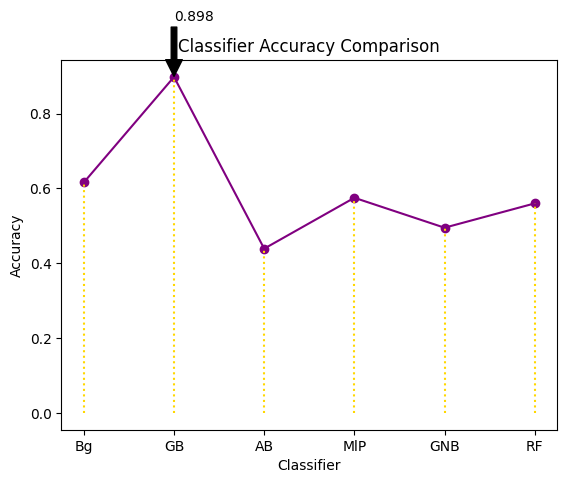

In [ ]:
import matplotlib.pyplot as plt

# Create lists of accuracies
classifiers = ['Bg', 'GB', 'AB', 'MlP', 'GNB', 'RF']
accuracies = [ 0.616, 0.898,0.439 ,0.575, 0.495, 0.560]

# Find the index of the highest accuracy
max_index = accuracies.index(max(accuracies))

# Create a line graph
plt.plot(classifiers, accuracies, marker='o', color='purple')

# Add dotted lines from classifiers to accuracies
for i in range(len(classifiers)):
    plt.plot([classifiers[i], classifiers[i]], [0, accuracies[i]], linestyle=':', color='gold')
    
# Add an arrow to the highest accuracy
plt.annotate(str(round(accuracies[max_index], 3)), xy=(classifiers[max_index], accuracies[max_index]), xytext=(classifiers[max_index], accuracies[max_index] + 0.15),
             arrowprops=dict(facecolor='black', shrink=0.01))

# Set the chart title and axis labels
plt.title('Classifier Accuracy Comparison')
plt.xlabel('Classifier')
plt.ylabel('Accuracy')

# Show the plot
plt.show()


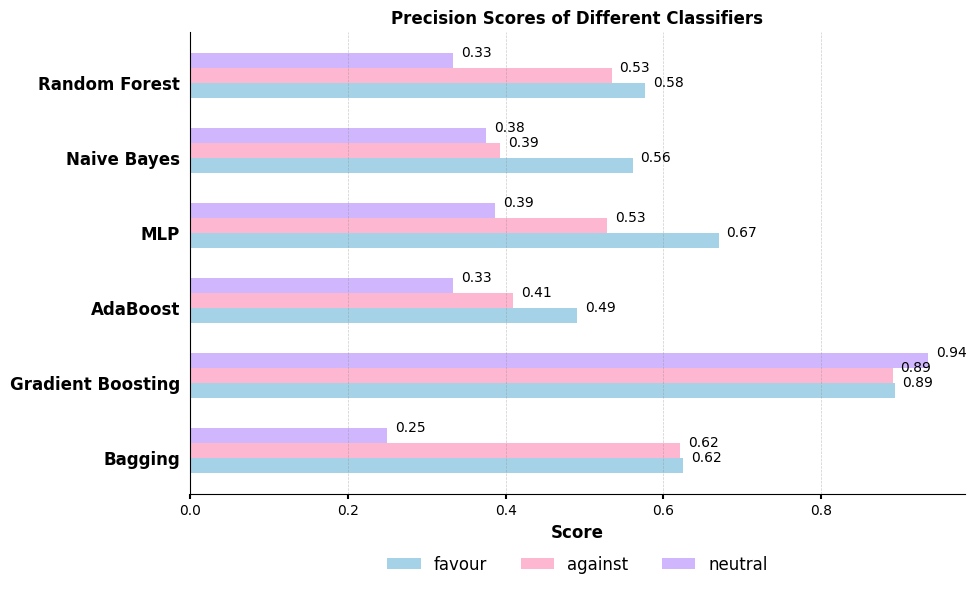

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define data
classifiers = ['Bagging', 'Gradient Boosting', 'AdaBoost', 'MLP', 'Naive Bayes', 'Random Forest']
precision = [ [0.625  ,    0.62162162 ,0.25      ]
, [0.89320388 ,0.890625,   0.93548387]
, [0.49038462 ,0.40983607 ,0.33333333]
, [0.67010309 ,0.52857143, 0.38709677]
, [0.56097561 ,0.39344262 ,0.375     ]
, [0.57664234 ,0.53448276 ,0.33333333]]
colors = ['#90c7e3', '#fda5c5', '#c5a5fd']

# Create plot
fig, ax = plt.subplots(figsize=(10, 6))

# Set bar width
bar_width = 0.2

# Create horizontal bars for each metric
for i, metric in enumerate(['favour', 'against', 'neutral']):
    ax.barh(np.arange(len(classifiers)) + i*bar_width, [p[i] for p in precision], height=bar_width, color=colors[i], alpha=0.8, label=metric)
    
# Set plot properties
ax.set_title('Precision Scores of Different Classifiers', fontweight='bold')
ax.set_yticks(np.arange(len(classifiers)) + bar_width/2)
ax.set_yticklabels(classifiers, fontweight='bold', fontsize=12)
ax.set_xlabel('Score', fontweight='bold', fontsize=12)
ax.xaxis.set_tick_params(width=1.5)
ax.yaxis.set_tick_params(width=0)
ax.xaxis.grid(color='gray', linewidth=0.5, linestyle='dashed', alpha=0.4)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3, frameon=False, fontsize=12)


# Remove spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Add value labels to bars
for i, classifier in enumerate(classifiers):
    for j, metric in enumerate(['favour', 'against', 'neutral']):
        value = precision[i][j]
        ax.text(value+0.01, i+j*bar_width+bar_width/2, f'{value:.2f}', va='center', fontsize=10)

# Show plot
plt.show()


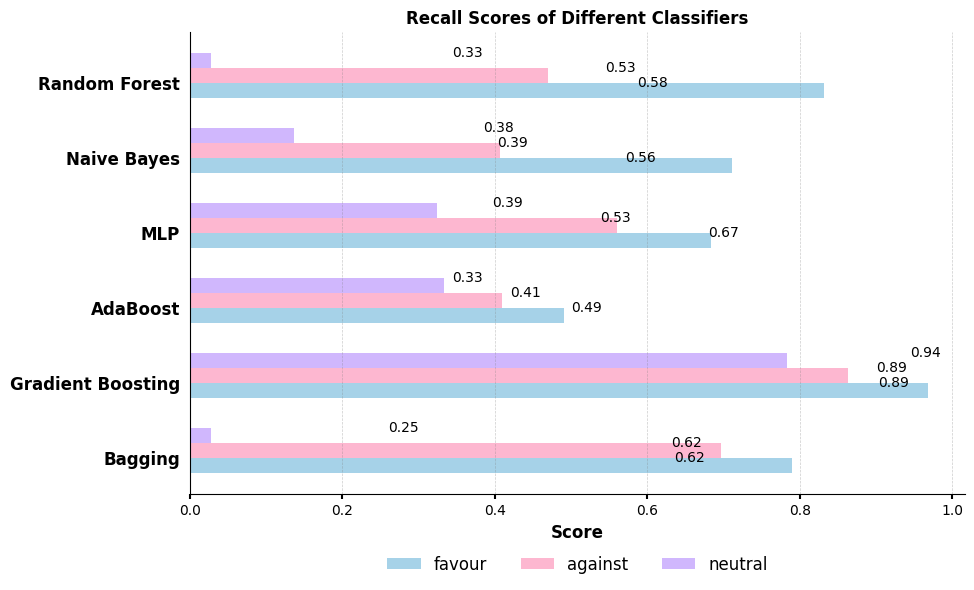

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define data
classifiers = ['Bagging', 'Gradient Boosting', 'AdaBoost', 'MLP', 'Naive Bayes', 'Random Forest']
recall = [[0.78947368 ,0.6969697 , 0.02702703]
,[0.96842105, 0.86363636 ,0.78378378]
,[0.49038462 ,0.40983607, 0.33333333]
,[0.68421053 ,0.56060606, 0.32432432]
, [0.71134021 ,0.40677966 ,0.13636364]
, [0.83157895 ,0.46969697 ,0.02702703]]
colors = ['#90c7e3', '#fda5c5', '#c5a5fd']

# Create plot
fig, ax = plt.subplots(figsize=(10, 6))

# Set bar width
bar_width = 0.2

# Create horizontal bars for each metric
for i, metric in enumerate(['favour', 'against', 'neutral']):
    ax.barh(np.arange(len(classifiers)) + i*bar_width, [r[i] for r in recall], height=bar_width, color=colors[i], alpha=0.8, label=metric)

# Set plot properties
ax.set_title('Recall Scores of Different Classifiers', fontweight='bold')
ax.set_yticks(np.arange(len(classifiers)) + bar_width/2)
ax.set_yticklabels(classifiers, fontweight='bold', fontsize=12)
ax.set_xlabel('Score', fontweight='bold', fontsize=12)
ax.xaxis.set_tick_params(width=1.5)
ax.yaxis.set_tick_params(width=0)
ax.xaxis.grid(color='gray', linewidth=0.5, linestyle='dashed', alpha=0.4)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3, frameon=False, fontsize=12)


# Remove spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Add value labels to bars
for i, classifier in enumerate(classifiers):
    for j, metric in enumerate(['favour', 'against', 'neutral']):
        value = precision[i][j]
        ax.text(value+0.01, i+j*bar_width+bar_width/2, f'{value:.2f}', va='center', fontsize=10)

# Show plot
plt.show()


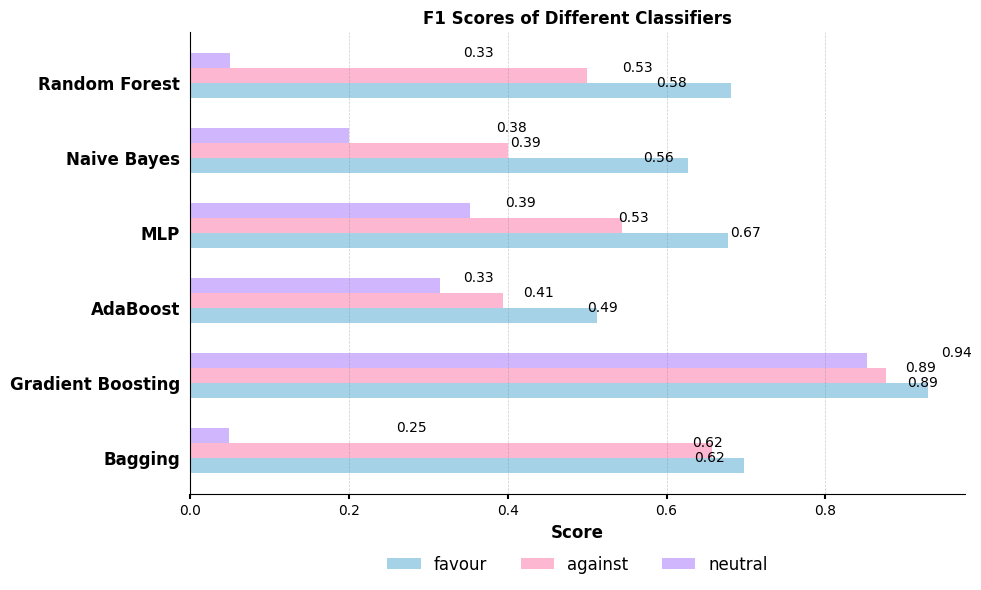

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define data
classifiers = ['Bagging', 'Gradient Boosting', 'AdaBoost', 'MLP', 'Naive Bayes', 'Random Forest']
f1_score = [ [0.69767442 ,0.65714286, 0.04878049] ,[0.92929293, 0.87692308 ,0.85294118] , [0.51256281 ,0.39370079, 0.31428571] ,
            [0.67708333 ,0.54411765, 0.35294118] , [0.62727273, 0.4 , 0.2 ] , [0.68103448, 0.5 , 0.05  ]]
colors = ['#90c7e3', '#fda5c5', '#c5a5fd']

# Create plot
fig, ax = plt.subplots(figsize=(10, 6))

# Set bar width
bar_width = 0.2

# Create horizontal bars for each metric
for i, metric in enumerate(['favour', 'against', 'neutral']):
    ax.barh(np.arange(len(classifiers)) + i*bar_width, [f[i] for f in f1_score], height=bar_width, color=colors[i], alpha=0.8, label=metric)

# Set plot properties
ax.set_title('F1 Scores of Different Classifiers', fontweight='bold')
ax.set_yticks(np.arange(len(classifiers)) + bar_width/2)
ax.set_yticklabels(classifiers, fontweight='bold', fontsize=12)
ax.set_xlabel('Score', fontweight='bold', fontsize=12)
ax.xaxis.set_tick_params(width=1.5)
ax.yaxis.set_tick_params(width=0)
ax.xaxis.grid(color='gray', linewidth=0.5, linestyle='dashed', alpha=0.4)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3, frameon=False, fontsize=12)


# Remove spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Add value labels to bars
for i, classifier in enumerate(classifiers):
    for j, metric in enumerate(['favour', 'against', 'neutral']):
        value = precision[i][j]
        ax.text(value+0.01, i+j*bar_width+bar_width/2, f'{value:.2f}', va='center', fontsize=10)

# Show plot
plt.show()


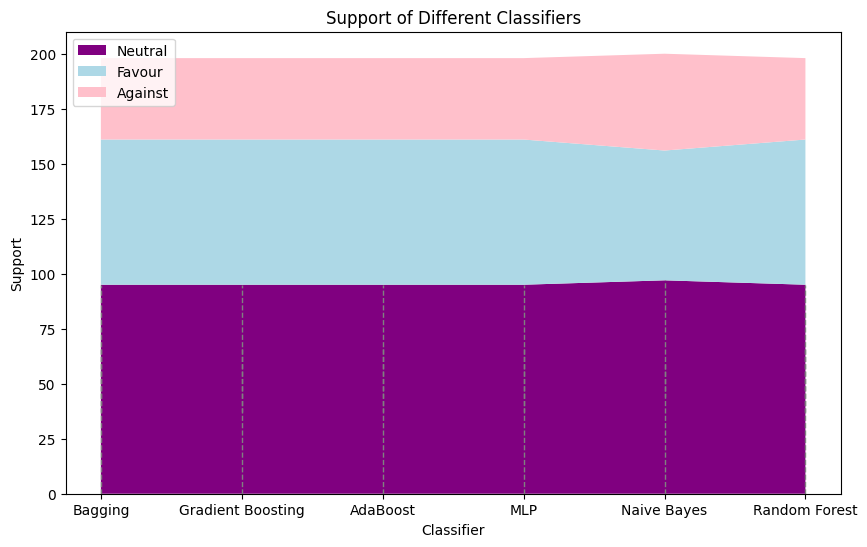

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define data
classifiers = ['Bagging', 'Gradient Boosting', 'AdaBoost', 'MLP', 'Naive Bayes', 'Random Forest']

stance = [ 'Neutral', 'Favour','Against']
support = np.array([[95 ,66, 37]
,[95, 66 ,37]
,[95, 66, 37]
,[95, 66 ,37]
,[97, 59 ,44]
,[95 ,66 ,37]])

# Create stacked area chart
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the stacked area chart
ax.stackplot(classifiers, support.T, labels=stance, colors=['purple', 'lightblue', 'pink'])

# Add borders and dotted lines from classifiers to support values
for i in range(len(classifiers)):
    for j in range(len(stance)):
        if j == 0:
            # Plot left border of stacked area chart
            ax.plot([classifiers[i], classifiers[i]], [0, support[i][j]], color='gray', linestyle='--', linewidth=1)
        elif j == len(stance) - 1:
            # Plot right border of stacked area chart
            ax.plot([classifiers[i], classifiers[i]], [support[i][j-1], support[i][j]], color='gray', linestyle='--', linewidth=1)
        else:
            # Plot dotted line for middle of stacked area chart
            y_start = support[i][j-1] + (support[i][j] - support[i][j-1]) / 2
            y_end = support[i][j] - (support[i][j] - support[i][j-1]) / 2
            ax.plot([classifiers[i], classifiers[i]], [y_start, y_end], color='gray', linestyle='--', linewidth=1)

# Set plot properties
ax.set_title('Support of Different Classifiers')
ax.set_xlabel('Classifier')
ax.set_ylabel('Support')
ax.legend(loc='upper left')

# Show plot
plt.show()
